In [63]:
# prelude
import pickle
import joblib
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error



# -----------------------------------------------------------------------------
from pathlib import Path
# k_CurrentDir  = Path(__file__).parent    # __file__ is not known in Jupyter context
k_Current_dir   = Path.cwd()
k_AssetsDir     = "assets"
k_Gold          = 1.618                    # gold number for ratio
k_Width         = 12
k_Height        = k_Width/k_Gold
k_WidthPx       = 1024
k_HeightPx      = k_WidthPx/k_Gold

k_random_state  = 42
k_test_size     = 0.2

In [64]:
# -----------------------------------------------------------------------------
def quick_View(df: pd.DataFrame) -> pd.DataFrame:

    """
    Generates a summary DataFrame for each column in the input DataFrame.

    This function analyzes each column in the given DataFrame and creates a summary that includes
    data type, number of null values, percentage of null values, number of non-null values, 
    number of distinct values, min and max values, outlier bounds (for numeric columns),
    and the frequency of distinct values.

    Args:
        df (pd.DataFrame): The input DataFrame to analyze.

    Returns:
        pd.DataFrame: A DataFrame containing the summary of each column from the input DataFrame. 
                      Each row in the resulting DataFrame represents a column from the input DataFrame
                      with the following information:
                      - "name": Column name
                      - "dtype": Data type of the column
                      - "# null": Number of null values
                      - "% null": Percentage of null values
                      - "# NOT null": Number of non-null values
                      - "distinct val": Number of distinct values
                      - "-3*sig": Lower bound for outliers (mean - 3*std) for numeric columns
                      - "min": Minimum value for numeric columns
                      - "mean" : Mean value for numeric columns
                      - "max": Maximum value for numeric columns
                      - "+3*sig": Upper bound for outliers (mean + 3*std) for numeric columns
                      - "distinct val count": Dictionary of distinct value counts or top 10 values for object columns
    """

    summary_lst = []
  
    for col_name in df.columns:
        col_dtype               = df[col_name].dtype
        num_of_null             = df[col_name].isnull().sum()
        percent_of_null         = num_of_null/len(df)
        num_of_non_null         = df[col_name].notnull().sum()
        num_of_distinct_values  = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts    = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts  = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        match col_dtype:
            case "int64":
                max_of_col  = df[col_name].max()
                min_of_col  = df[col_name].min()
                mean_of_col = df[col_name].mean()
                outlier_hi  = df[col_name].mean() + 3*df[col_name].std()
                outlier_lo  = df[col_name].mean() - 3*df[col_name].std()
            case "bool":
                max_of_col  = int(df[col_name].max())
                min_of_col  = int(df[col_name].min())
                mean_of_col = float(df[col_name].mean())
                outlier_hi  = 1 
                outlier_lo  = 0 
            case _:                        # "object" ...
                max_of_col = -1
                min_of_col =  1
                mean_of_col = np.nan
                outlier_hi = -1
                outlier_lo =  1

        summary_lst.append({
            "name"                : col_name,
            "dtype"               : col_dtype,
            "# null"              : num_of_null,
            "% null"              : (100*percent_of_null).round(2),
            "# NOT null"          : num_of_non_null,
            "distinct val"        : num_of_distinct_values,
            "-3*sig"              : round(outlier_lo,2),
            "min"                 : round(min_of_col,2),
            "mean"                : round(mean_of_col,2),
            "max"                 : round(max_of_col,2),
            "+3*sig"              : round(outlier_hi,2) ,
            "distinct val count"  : distinct_values_counts
        })

    df_tmp = pd.DataFrame(summary_lst)
    return df_tmp

In [65]:
# -----------------------------------------------------------------------------
def remove_Outliers_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # TODO try this : 
    # df = df[~((df[column] < (Q1 - 1.5*IQR)) | (df[column] > (Q3 + 1.5*IQR)))]
    df = df[((df[column] >= lower_bound) & (df[column] <= upper_bound)) | df[column].isna()]
    return df


# -----------------------------------------------------------------------------
# Remove outliers using z-score
# TODO : try this instead (smarter)
# from scipy import stats
# df = df[(np.abs(stats.zscore(df[['price']])) < 3)]

def remove_Outliers_Sigma(df, column):
    mean_col = df[column].mean()
    sigma_col = df[column].std()

    lower_bound = mean_col - 3 * sigma_col
    upper_bound = mean_col + 3 * sigma_col
    df = df[((df[column] >= lower_bound) & (df[column] <= upper_bound)) | df[column].isna()]
    return df

# -----------------------------------------------------------------------------
# method = "IQR" or "sigma"
# Ex : df = remove_Outliers(df, "rental_price_per_day", method="sigma")
def remove_Outliers(df, column, method="sigma"):
    match method:
        case "IQR":
            df = remove_Outliers_IQR(df, column)
        case "sigma":
            df = remove_Outliers_Sigma(df, column)
        case _:
            raise Exception("method must be IQR or sigma")    
    return df



In [66]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = Path(f"{k_Current_dir/k_AssetsDir/fig_id}.{fig_extension}")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return

# getaround project - pricing

# <span style="color:red"><b>TODO & Ideas - TO BE COMMENTED</b></span>

* https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

# Specifications 

* https://app.jedha.co/course/project-deployment-ft/getaround-analysis-ft


# EDA 

In [67]:
# df = pd.read_csv('https://full-stack-assets.s3.eu-west-3.amazonaws.com/Deployment/get_around_pricing_project.csv')
df = pd.read_csv(k_Current_dir/k_AssetsDir/"get_around_pricing_project.csv")

print(f"\n\nPreview of the dataset :")
display(df.sample(15))



Preview of the dataset :


,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
3449,3449,Renault,184233,77,petrol,grey,sedan,False,False,False,False,False,False,True,20
730,730,Renault,149817,85,diesel,white,estate,False,True,False,False,False,False,True,107
2616,2616,Renault,129929,135,diesel,black,sedan,True,True,False,False,True,False,True,130
3289,3289,Citroën,117770,120,diesel,black,sedan,False,True,False,False,False,False,True,115
4427,4427,Subaru,154251,225,petrol,white,suv,True,True,False,True,True,True,True,134
3528,3528,Renault,125287,120,diesel,grey,sedan,True,True,True,False,True,False,True,136
1119,1119,Citroën,162042,135,diesel,blue,estate,True,True,True,True,True,True,True,103
1726,1726,Audi,171496,100,diesel,brown,estate,True,True,False,False,True,False,True,117
1907,1907,BMW,121953,85,diesel,grey,hatchback,False,False,False,False,False,False,True,80
1635,1635,Audi,266060,150,diesel,black,estate,True,True,True,False,True,True,True,124


## What is Unnamed: 0?

In [68]:
print(len(df))
print(df["Unnamed: 0"].value_counts)


4843
<bound method IndexOpsMixin.value_counts of 0          0
1          1
2          2
3          3
4          4
        ... 
4838    4838
4839    4839
4840    4840
4841    4841
4842    4842
Name: Unnamed: 0, Length: 4843, dtype: int64>


### <span style="color:orange"><b>Comments :</b></span>
*  ``Unnamed: 0`` is an index


## Missing values

In [69]:
print(f"\n\n% of missing values :")
display(round(df.isnull().sum()/len(df)*100, 2))


Unnamed: 0                   0.0
model_key                    0.0
mileage                      0.0
engine_power                 0.0
fuel                         0.0
paint_color                  0.0
car_type                     0.0
private_parking_available    0.0
has_gps                      0.0
has_air_conditioning         0.0
automatic_car                0.0
has_getaround_connect        0.0
has_speed_regulator          0.0
winter_tires                 0.0
rental_price_per_day         0.0
dtype: float64

### <span style="color:orange"><b>Comments :</b></span>
* No missing value 


In [70]:
# -----------------------------------------------------------------------------
def preprocessor(df):
    # drop
    # df.drop(columns="Unnamed: 7", inplace=True)
    # df.drop_duplicates(inplace=True)

    # rename
    df.rename(
        columns={
            "Unnamed: 0": "id", 
        }, 
        inplace=True
    )

    # format 
    df.columns = df.columns.str.lower()
    # df.columns = df.columns.str.replace("/", "_")

    
                  
    # cast 
    # df['rental_id'] = df['rental_id'].astype(str)
    # df['car_id'] = df['car_id'].astype(str)
    # df['previous_ended_rental_id'] = df['previous_ended_rental_id'].astype(str)
    # df['previous_ended_rental_id'] = df['previous_ended_rental_id'].apply(lambda x: str(int(x)) if not pd.isna(x) else x)

    # other preprocessing should come here
    # df["time_slot"] = (df["hour"]*60 + df["minute"])//k_time_slot_len

    # set index
    df.set_index('id', inplace=True)

    return df

In [71]:
df = preprocessor(df)
print(f"\n\nPreview of the preprocessed dataset :")
# display(df.head())
display(df.sample(15))



Preview of the preprocessed dataset :


,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
id,,,,,,,,,,,,,,
1030,Audi,230365,145,diesel,black,estate,True,True,True,False,True,True,True,85
4119,Mitsubishi,117507,190,diesel,black,suv,True,True,True,True,True,False,True,186
1215,Renault,119515,135,diesel,grey,estate,False,True,False,False,True,False,True,141
2345,BMW,163618,85,diesel,black,hatchback,False,True,False,False,False,False,True,93
3599,Audi,90925,190,diesel,blue,sedan,True,True,False,True,True,False,True,146
4371,Nissan,80489,135,diesel,grey,suv,True,True,False,False,False,False,False,128
203,Peugeot,153585,105,diesel,white,estate,False,False,False,False,False,False,False,117
1745,Citroën,171327,120,diesel,black,estate,True,True,False,False,False,True,True,107
4634,BMW,251368,210,diesel,black,suv,True,True,True,False,True,True,True,104


## Data overview

In [91]:
print(f"\n\nThis is a regression problem")

print(f"\n\nThe target is rental_price_per_day")

print(f"\n\nThe dataset consists of :")
print(f"\t{len(df.shape):>9_} dimensions")
print(f"\t{df.shape[0]:>9_} observations")
print(f"\t{df.shape[1]:>9_} features    ")

df_types = pd.DataFrame ({
  "types" : df.dtypes.value_counts()
})
df_types["as_%"] = (100 * df_types["types"]/df_types["types"].sum()).round(2)

print(f"\n\n% of data type :")
display(df_types)

df_tmp = quick_View(df)
print(f"\n\nQuickView :")
display(df_tmp.sort_values(by="# null", ascending=False))   



This is a regression problem


The target is rental_price_per_day


The dataset consists of :
	        2 dimensions
	    4_843 observations
	       14 features    


% of data type :


,types,as_%
bool,7,50.00
object,4,28.57
int64,3,21.43




QuickView :


,name,dtype,# null,% null,# NOT null,distinct val,-3*sig,min,mean,max,+3*sig,distinct val count
0,model_key,object,0,0.0,4843,28,1.00,1,NaN,-1,-1.00,"{'Citroën': 969, 'Renault': 916, 'BMW': 827, '..."
1,mileage,int64,0,0.0,4843,4786,-39627.42,-64,140962.80,1000376,321553.02,"{123492: 2, 108352: 2, 180606: 2, 72760: 2, 78..."
2,engine_power,int64,0,0.0,4843,61,12.01,0,128.99,423,245.97,"{135: 882, 120: 785, 85: 631, 100: 570, 105: 4..."
3,fuel,object,0,0.0,4843,4,1.00,1,NaN,-1,-1.00,"{'diesel': 4641, 'petrol': 191, 'hybrid_petrol..."
4,paint_color,object,0,0.0,4843,10,1.00,1,NaN,-1,-1.00,"{'black': 1633, 'grey': 1175, 'blue': 710, 'wh..."
5,car_type,object,0,0.0,4843,8,1.00,1,NaN,-1,-1.00,"{'estate': 1606, 'sedan': 1168, 'suv': 1058, '..."
6,private_parking_available,bool,0,0.0,4843,2,0.00,0,0.55,1,1.00,"{True: 2662, False: 2181}"
7,has_gps,bool,0,0.0,4843,2,0.00,0,0.79,1,1.00,"{True: 3839, False: 1004}"
8,has_air_conditioning,bool,0,0.0,4843,2,0.00,0,0.20,1,1.00,"{False: 3865, True: 978}"
9,automatic_car,bool,0,0.0,4843,2,0.00,0,0.20,1,1.00,"{False: 3881, True: 962}"


### <span style="color:orange"><b>Comments :</b></span>
* Outliers in ``mileage``, `engine_power` and `rental_price_per_day`
* `has_gps`, `has_air_conditioning`, `automatic_car`, `has_speed_regulator` are unbalanced in a ratio of 1 to 4
* `diesel` is by far the most popular engine type (97%, $\frac{4641}{4843}$)

## About model_key

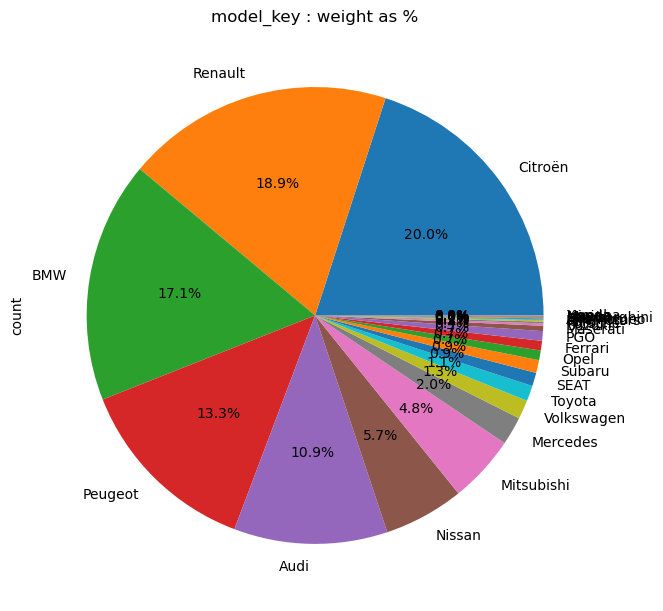

In [73]:
counts = df["model_key"].value_counts()
# print(f"Nb mobile  : {counts['mobile']:>7_}")
# print(f"Nb connect : {counts['connect']:>7_}")

_ = counts.plot.pie(title="model_key : weight as %", autopct="%1.1f%%", figsize=(k_Width, k_Height))

### <span style="color:orange"><b>Comments :</b></span>
* More than 80% of the cars available covered with 5 different brands ($\frac{5}{28}$, 17%, Pareto is almost verified)  


## Focus on engine_power, mileage and rental_price_per_day

### Shape of the disptributions

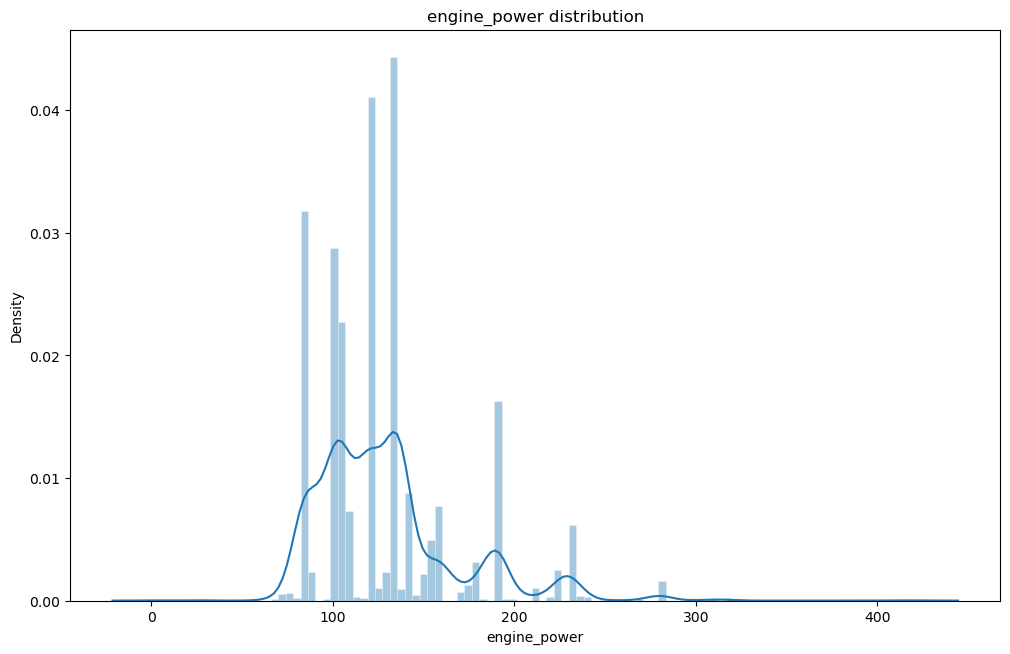

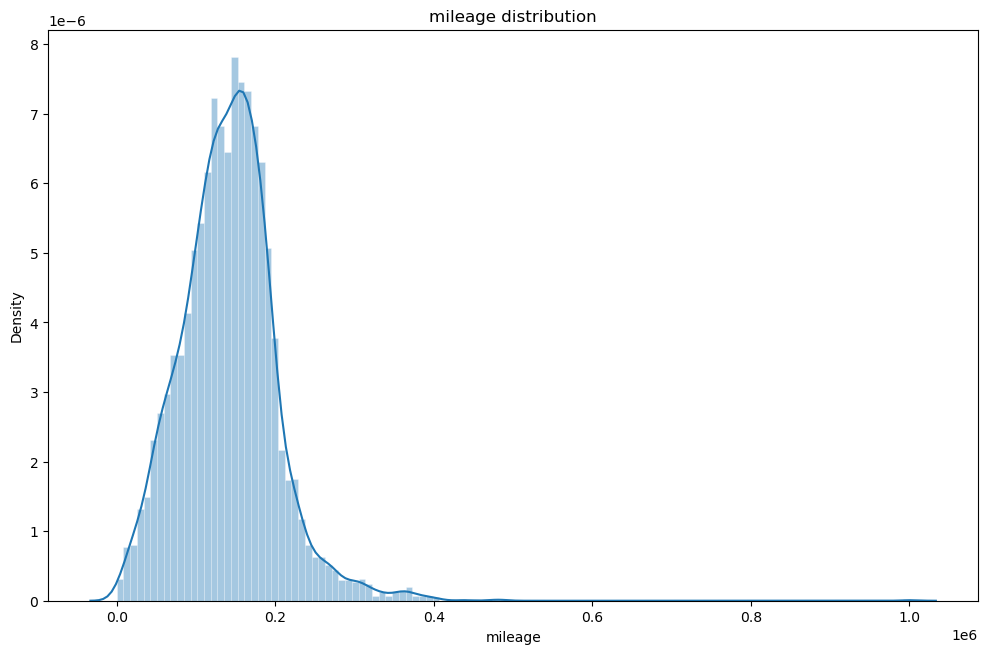

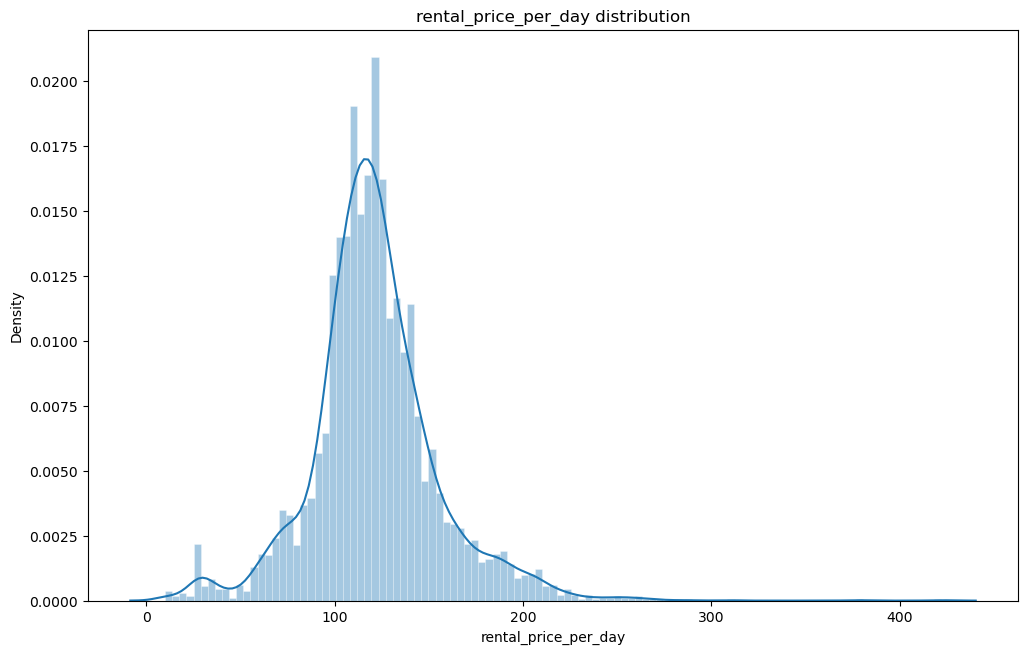

In [74]:
features = ["engine_power", "mileage", "rental_price_per_day"]
for feature in features:
    fig, ax = plt.subplots(figsize=(k_Width,k_Height))
    sns.histplot(df[feature], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4)) 
    ax.set_title(f"{feature} distribution")
    ax.set_xlabel(f"{feature}")


### <span style="color:orange"><b>Comments :</b></span>
* `engine_power` in not a nice bell-curve. If outliers are removed we should use 1.5*IQR 
* ``mileage`` & ``rental_price_per_day`` are bell curves. If outliers are removed we should use 3$\sigma$  


### Vizualise outliers

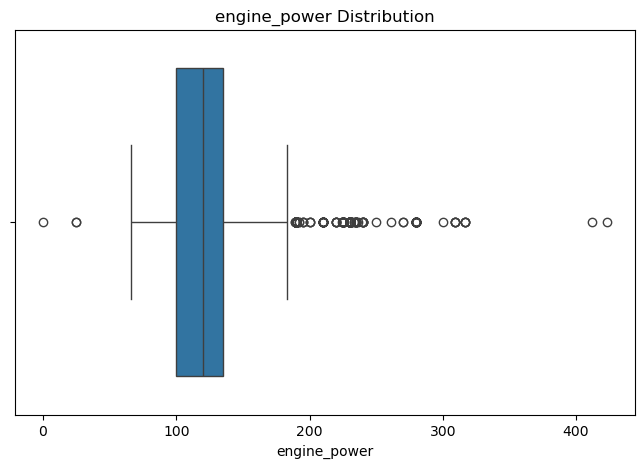

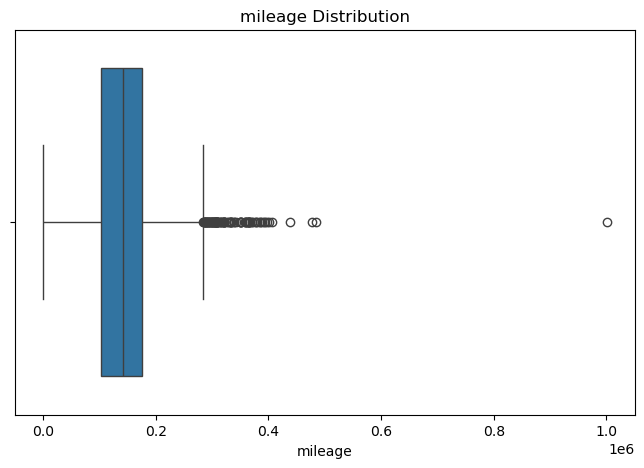

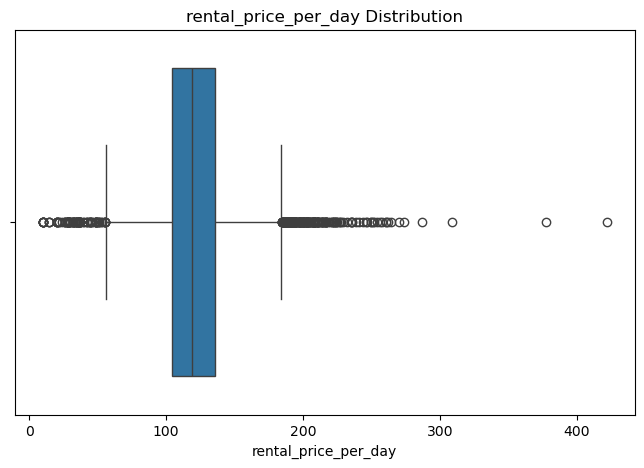

In [75]:
features = ["engine_power", "mileage", "rental_price_per_day"]
for feature in features:
    fig, ax = plt.subplots(figsize=(8,5))
    # Il y a un warning à propos de la palette et de hue
    # sns.boxplot(tips, x='total_bill', palette="coolwarm")
    sns.boxplot(df, x=feature)
    ax.set_title(f"{feature} Distribution")
    ax.set_xlabel(f"{feature}")

In [76]:
# Using XGBoost I get better results keeping outliers
# Indeed, this model is often robust to outliers as it uses decision trees, which are less sensitive to extreme values. 
# This is, may be, the case here but it seems outliers provide useful information that helps improve predictions

# df = remove_Outliers(df, "engine_power", method="IQR")
# df = remove_Outliers(df, "mileage", method="sigma")
# df = remove_Outliers(df, "rental_price_per_day", method="sigma")

df_tmp = quick_View(df)
print(f"\n\nQuickView after outliers removal:")
display(df_tmp.sort_values(by="# null", ascending=False))   



QuickView after outliers removal:


,name,dtype,# null,% null,# NOT null,distinct val,-3*sig,min,mean,max,+3*sig,distinct val count
0,model_key,object,0,0.0,4843,28,1.00,1,NaN,-1,-1.00,"{'Citroën': 969, 'Renault': 916, 'BMW': 827, '..."
1,mileage,int64,0,0.0,4843,4786,-39627.42,-64,140962.80,1000376,321553.02,"{123492: 2, 108352: 2, 180606: 2, 72760: 2, 78..."
2,engine_power,int64,0,0.0,4843,61,12.01,0,128.99,423,245.97,"{135: 882, 120: 785, 85: 631, 100: 570, 105: 4..."
3,fuel,object,0,0.0,4843,4,1.00,1,NaN,-1,-1.00,"{'diesel': 4641, 'petrol': 191, 'hybrid_petrol..."
4,paint_color,object,0,0.0,4843,10,1.00,1,NaN,-1,-1.00,"{'black': 1633, 'grey': 1175, 'blue': 710, 'wh..."
5,car_type,object,0,0.0,4843,8,1.00,1,NaN,-1,-1.00,"{'estate': 1606, 'sedan': 1168, 'suv': 1058, '..."
6,private_parking_available,bool,0,0.0,4843,2,0.00,0,0.55,1,1.00,"{True: 2662, False: 2181}"
7,has_gps,bool,0,0.0,4843,2,0.00,0,0.79,1,1.00,"{True: 3839, False: 1004}"
8,has_air_conditioning,bool,0,0.0,4843,2,0.00,0,0.20,1,1.00,"{False: 3865, True: 978}"
9,automatic_car,bool,0,0.0,4843,2,0.00,0,0.20,1,1.00,"{False: 3881, True: 962}"


# Model

In [77]:
target_name = "rental_price_per_day"

X = df.drop(columns=target_name)
# display(X)
y = df[target_name]
# display(y)

num_features = X.select_dtypes(include="number").columns
# print(num_features)
cat_features = X.select_dtypes(exclude="number").columns
# print(cat_features)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=k_test_size, random_state=k_random_state)


In [78]:

num_pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),
    ]
)

cat_pipeline = Pipeline(
    [
        ('encoder', OneHotEncoder(drop='first')), 
    ]
)


full_pipeline = ColumnTransformer(
    [
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ]
)

In [79]:
X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

with open(k_Current_dir/k_AssetsDir/'full_pipeline.pkl', 'wb') as file:
    pickle.dump(full_pipeline, file)

In [80]:
# R² : measures the proportion of variance explained by the model
# It is used to judge how close the predictions are to the actual values 
# An R² close to 1 means that the model explains 100% of data variability
# MSE (Mean Squared Error): penalizes larger errors, which can be useful for detecting inaccurate extreme predictions
# MAE (Mean Absolute Error): measures the mean absolute error, giving a simpler, more intuitive idea of the errors committed by the model

# R² train vs. R² test: Compare these two values to check whether your model is overfitting. 
# A large difference between R² train and R² test may indicate overfitting.
# MSE and MAE: These metrics give you an idea of the magnitude of errors. 
# If MSE is much larger than MAE, this may indicate the presence of outliers with a strong impact on the error.

# A good model will have a high test R², close to the train R², and relatively low errors (MSE/MAE). If these errors are low on the test set, this indicates a good ability to generalize.


metrics_df = pd.DataFrame(columns=['Model', 'R2_Train', 'R2_Test', 'MAE', 'MSE'])

## Baseline model - Linear Regression

In [81]:
lreg = LinearRegression()
lreg.fit(X_train, y_train)

y_train_pred = lreg.predict(X_train)
r2_train = lreg.score(X_train, y_train)

y_test_pred = lreg.predict(X_test)
r2_test = lreg.score(X_test, y_test)

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100


row = pd.DataFrame({'Model': ["Linear Reg"], 'R2_Train': [r2_train], 'R2_Test': [r2_test], 'MAE': [mae], 'MSE': [mse]})  
metrics_df = pd.concat([metrics_df, row], ignore_index=True)
display(metrics_df)


C:\Users\phili\AppData\Local\Temp\ipykernel_21612\2763411367.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, row], ignore_index=True)


,Model,R2_Train,R2_Test,MAE,MSE
0,Linear Reg,0.71401,0.693716,12.115369,322.585947


In [90]:

reg_xgb = xgboost.XGBRegressor()

param_grid = {
    # most important
    'n_estimators': [200, 300, 400],      # Number of trees in the model (more trees potentially means better performance, but also more computation time).
    'learning_rate': [0.01, 0.05, 0.1, 0.3],    # The learning rate, which controls the importance given to each tree. Smaller values make the model more accurate, but require more estimators.
    'max_depth': [3, 5, 7, 10],                 # Maximum tree depth. Deeper trees can capture complex relationships, but also risk overfitting.
    
    # important
    # 'subsample': [0.5, 0.7, 0.8, 1],          # Fraction of samples used to fit each trees (can help to reduce overfit)
    'colsample_bytree': [0.5, 0.7, 1],          # Fraction of features used to fit trees (can help to reduce overfit if lot of features)
    'gamma': [0, 0.1, 0.3, 0.5],                # Minimum loss reduction required to make a further partition on a leaf node
    'min_child_weight': [1, 3, 5],              # Minimum leaf weight. Controls the minimum size of a decision node in the tree. A higher weight prevents trees from learning small partitions with little importance, thus avoiding overfitting.
    
    # secondary hyperparameters
    # "lambda" : [0, 0.1, 1, 10],               # lambda L2 regulation  or alpha regulation L1
    # "booster " : "dart"                       # try dart if overfitting (default is gbtree)
}

# grid_search_xgb = RandomizedSearchCV(reg_xgb, param_grid, cv=5, scoring='r2', random_state=k_random_state) 
grid_search_xgb = GridSearchCV(reg_xgb, param_grid, cv=5, scoring='r2')
grid_search_xgb.fit(X_train, y_train)
print("Best hyperparameters : ", grid_search_xgb.best_params_)

# train
r2_train = grid_search_xgb.best_score_

# test
best_xgb_model = grid_search_xgb.best_estimator_
y_test_pred_xgb = best_xgb_model.predict(X_test)
r2_test = best_xgb_model.score(X_test, y_test)
mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_test_pred_xgb)

row = pd.DataFrame({'Model': ["XGBoost"], 'R2_Train': [r2_train], 'R2_Test': [r2_test], 'MAE': [mae_xgb], 'MSE': [mse_xgb]})
metrics_df = pd.concat([metrics_df, row], ignore_index=True)

display(metrics_df)

_ = joblib.dump(best_xgb_model, k_Current_dir/k_AssetsDir/"model_xgb.pkl")


Best hyperparameters :  {'colsample_bytree': 0.7, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 400}


,Model,R2_Train,R2_Test,MAE,MSE
0,Linear Reg,0.714010,0.693716,12.115369,322.585947
1,XGBoost,0.766747,0.756216,10.312156,256.759281
2,XGBoost,0.765971,0.750675,10.398717,262.595141
3,XGBoost,0.766747,0.756216,10.312156,256.759281
4,XGBoost,0.765971,0.750675,10.398717,262.595141
5,XGBoost,0.778500,0.761657,10.014365,251.028420
6,XGBoost,0.766747,0.756216,10.312156,256.759281
7,XGBoost,0.776596,0.760239,10.087709,252.522378
8,XGBoost,0.778095,0.754231,10.293056,258.850062


# <span style="color:red"><b>Scrap book - Please ignore</b></span>